## Data Pre-processing
Most of the data cleaning was conducted on Google Sheets. The imported dataset `data` contains data from the  “LBA data gathering” [spreadsheet](https://docs.google.com/spreadsheets/d/10dvaoDs67xPEqfn3EGtuXE2wthvIlnEiAly_Amydj3g/edit?usp=sharing) where the columns 'Timestamp', 'Email address' and 'Your name' dropped and the product headers have been renamed. An additional column ‘Location’ has been added and contains information on each store’s neighborhood from the “LBA data collection” [spreadsheet](https://docs.google.com/spreadsheets/d/16ZSrZZqMPmcPkKjRQU0x1LE_BSulmDVrRfSyBQ3aCbg/edit?usp=sharing). Lastly, I normalized the prices for each product and removed the data from  Lotte Mart as it only represents one data point from South Korea and would, therefore, be an outlier


In [0]:
#importing the required libraries
%matplotlib inline
import pystan
import numpy as np
import pandas as pd
import scipy.stats as sts
from scipy import stats
import matplotlib.pyplot as plt

In [35]:
#loading and previewing grocery store data
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQoe0jJnNeKWc6koLjy32A32fN-7m6Ae9n0UJg7_QqcXuo7gRvEXb7QZiumtgkpPTE1czLnsVKRtiBf/pub?gid=0&single=true&output=csv")
data.head()

,Store,Location,Normalized_Apple_brand_1,Normalized_Apple_brand_2,Normalized_Apple_brand_3,Normalized_Banana_brand_1,Normalized_Banana_brand_2,Normalized_Banana_brand_3,Normalized_Tomato_brand_1,Normalized_Tomato_brand_2,Normalized_Tomato_brand_3,Normalized_Potato_brand_1,Normalized_Potato_brand_2,Normalized_Potato_brand_3,Normalized_Flour_brand_1,Normalized_Flour_brand_2,Normalized_Flour_brand_3,Normalized_Rice_brand_1,Normalized_Rice_brand_2,Normalized_Rice_brand_3,Normalized_Milk_brand_1,Normalized_Milk_brand_2,Normalized_Milk_brand_3,Normalized_Butter_brand_1,Normalized_Butter_brand_2,Normalized_Butter_brand_3,Normalized_Eggs_brand_1,Normalized_Eggs_brand_2,Normalized_Eggs_brand_3,Normalized_Chicken_brand_1,Normalized_Chicken_brand_2,Normalized_Chicken_brand_3
0,ALDI,Lichtenberg,2.50,1.88,3.15,1.69,0.99,NaN,3.52,2.98,1.89,0.56,0.50,1.25,0.39,NaN,NaN,1.99,NaN,NaN,0.99,3.15,0.99,5.56,6.36,9.56,0.12,0.27,0.16,6.65,5.99,NaN
1,ALDI,Neukölln,2.99,1.79,2.36,1.15,1.69,1.5,3.58,1.99,4.58,0.56,1.33,0.80,0.39,1.49,1.39,3.98,NaN,NaN,1.05,0.71,0.99,9.56,5.16,5.16,0.16,0.12,0.27,6.65,5.99,11.40
2,ALDI,Neukölln,1.25,1.79,1.15,1.15,1.69,NaN,1.99,2.29,2.29,0.46,0.56,NaN,0.39,NaN,NaN,1.99,NaN,NaN,0.63,0.71,0.99,5.56,8.76,9.56,0.16,0.12,0.27,6.65,5.99,NaN
3,ALDI,Kreuzberg,2.99,1.79,2.29,1.15,1.69,NaN,6.30,2.80,2.38,0.60,1.30,0.56,0.39,NaN,NaN,1.99,NaN,NaN,1.05,0.95,0.63,9.56,6.36,5.56,0.16,0.12,0.27,6.65,7.48,6.98
4,ALDI,Kreuzberg,3.25,1.15,1.39,1.69,1.15,NaN,1.99,2.38,4.58,0.58,0.56,NaN,0.39,NaN,NaN,0.98,NaN,NaN,0.71,0.99,NaN,6.36,5.56,9.96,0.16,0.12,0.27,8.54,6.65,5.99


In [36]:
## Since we'll be feeding this dataset into Stan, we have to convert all string variables into numbers ##

data_1 = data.copy() #copy data and save it into a new dataframe

#create two dictionaries, store_dict and location_dict where I'll assign 
#numbers to the strings and map them into the `data_1` dataframe
store_dict = { "ALDI": 1, "EDEKA":2, "Lidl":3, "REWE":4, "Safeway": 5, 
              "Sainsbury's": 6, "Tesco Express": 7, "Waitrose & Partners":8}

data_1['Store'] = data_1['Store'].map(store_dict)

location_dict = { "Alt-Treptow": 1, "Barbican": 2, "Clapton": 3, "Crouch End": 4, "Elephants and Castle": 5,
                 "Farringdon": 6, "Fitzrovia": 7, "Friedrichshain": 8, "Hoxton": 9, "Islington": 10, 
                 "Kreuzberg": 11, "Lichtenberg": 12, "Marylebone": 13, "Mayfair": 14, "Mitte": 15, "Mountain View": 16,
                 "Neukölln": 17, "Palo Alto": 18, "Prenzlauer Berg": 19, "Saint Pancras": 20, "San Francisco": 21, 
                 "Schöneberg": 22, "Shoreditch": 23, "Tempelhof": 24}

data_1['Location'] = data_1['Location'].map(location_dict)

data_1.head()


,Store,Location,Normalized_Apple_brand_1,Normalized_Apple_brand_2,Normalized_Apple_brand_3,Normalized_Banana_brand_1,Normalized_Banana_brand_2,Normalized_Banana_brand_3,Normalized_Tomato_brand_1,Normalized_Tomato_brand_2,Normalized_Tomato_brand_3,Normalized_Potato_brand_1,Normalized_Potato_brand_2,Normalized_Potato_brand_3,Normalized_Flour_brand_1,Normalized_Flour_brand_2,Normalized_Flour_brand_3,Normalized_Rice_brand_1,Normalized_Rice_brand_2,Normalized_Rice_brand_3,Normalized_Milk_brand_1,Normalized_Milk_brand_2,Normalized_Milk_brand_3,Normalized_Butter_brand_1,Normalized_Butter_brand_2,Normalized_Butter_brand_3,Normalized_Eggs_brand_1,Normalized_Eggs_brand_2,Normalized_Eggs_brand_3,Normalized_Chicken_brand_1,Normalized_Chicken_brand_2,Normalized_Chicken_brand_3
0,1,12,2.50,1.88,3.15,1.69,0.99,NaN,3.52,2.98,1.89,0.56,0.50,1.25,0.39,NaN,NaN,1.99,NaN,NaN,0.99,3.15,0.99,5.56,6.36,9.56,0.12,0.27,0.16,6.65,5.99,NaN
1,1,17,2.99,1.79,2.36,1.15,1.69,1.5,3.58,1.99,4.58,0.56,1.33,0.80,0.39,1.49,1.39,3.98,NaN,NaN,1.05,0.71,0.99,9.56,5.16,5.16,0.16,0.12,0.27,6.65,5.99,11.40
2,1,17,1.25,1.79,1.15,1.15,1.69,NaN,1.99,2.29,2.29,0.46,0.56,NaN,0.39,NaN,NaN,1.99,NaN,NaN,0.63,0.71,0.99,5.56,8.76,9.56,0.16,0.12,0.27,6.65,5.99,NaN
3,1,11,2.99,1.79,2.29,1.15,1.69,NaN,6.30,2.80,2.38,0.60,1.30,0.56,0.39,NaN,NaN,1.99,NaN,NaN,1.05,0.95,0.63,9.56,6.36,5.56,0.16,0.12,0.27,6.65,7.48,6.98
4,1,11,3.25,1.15,1.39,1.69,1.15,NaN,1.99,2.38,4.58,0.58,0.56,NaN,0.39,NaN,NaN,0.98,NaN,NaN,0.71,0.99,NaN,6.36,5.56,9.96,0.16,0.12,0.27,8.54,6.65,5.99


The next step is to reshape `data_1` such that the resulting data is tidy (that is, the dataset is arranged such that each variable is a column and each observation is a row). The underlying assumption that makes this possible is that although we were collecting different brands of the same product, we did not record the information about the brand name. Therefore, we assume that the three data points are essentially of the same product which allows us to combine every obervation of the variable into a column




In [37]:
matrix = data_1.iloc[:,2:]
matrix.head()

,Normalized_Apple_brand_1,Normalized_Apple_brand_2,Normalized_Apple_brand_3,Normalized_Banana_brand_1,Normalized_Banana_brand_2,Normalized_Banana_brand_3,Normalized_Tomato_brand_1,Normalized_Tomato_brand_2,Normalized_Tomato_brand_3,Normalized_Potato_brand_1,Normalized_Potato_brand_2,Normalized_Potato_brand_3,Normalized_Flour_brand_1,Normalized_Flour_brand_2,Normalized_Flour_brand_3,Normalized_Rice_brand_1,Normalized_Rice_brand_2,Normalized_Rice_brand_3,Normalized_Milk_brand_1,Normalized_Milk_brand_2,Normalized_Milk_brand_3,Normalized_Butter_brand_1,Normalized_Butter_brand_2,Normalized_Butter_brand_3,Normalized_Eggs_brand_1,Normalized_Eggs_brand_2,Normalized_Eggs_brand_3,Normalized_Chicken_brand_1,Normalized_Chicken_brand_2,Normalized_Chicken_brand_3
0,2.50,1.88,3.15,1.69,0.99,NaN,3.52,2.98,1.89,0.56,0.50,1.25,0.39,NaN,NaN,1.99,NaN,NaN,0.99,3.15,0.99,5.56,6.36,9.56,0.12,0.27,0.16,6.65,5.99,NaN
1,2.99,1.79,2.36,1.15,1.69,1.5,3.58,1.99,4.58,0.56,1.33,0.80,0.39,1.49,1.39,3.98,NaN,NaN,1.05,0.71,0.99,9.56,5.16,5.16,0.16,0.12,0.27,6.65,5.99,11.40
2,1.25,1.79,1.15,1.15,1.69,NaN,1.99,2.29,2.29,0.46,0.56,NaN,0.39,NaN,NaN,1.99,NaN,NaN,0.63,0.71,0.99,5.56,8.76,9.56,0.16,0.12,0.27,6.65,5.99,NaN
3,2.99,1.79,2.29,1.15,1.69,NaN,6.30,2.80,2.38,0.60,1.30,0.56,0.39,NaN,NaN,1.99,NaN,NaN,1.05,0.95,0.63,9.56,6.36,5.56,0.16,0.12,0.27,6.65,7.48,6.98
4,3.25,1.15,1.39,1.69,1.15,NaN,1.99,2.38,4.58,0.58,0.56,NaN,0.39,NaN,NaN,0.98,NaN,NaN,0.71,0.99,NaN,6.36,5.56,9.96,0.16,0.12,0.27,8.54,6.65,5.99


In [38]:
columns = matrix.columns
columns

Index(['Normalized_Apple_brand_1', 'Normalized_Apple_brand_2',
       'Normalized_Apple_brand_3', 'Normalized_Banana_brand_1',
       'Normalized_Banana_brand_2', 'Normalized_Banana_brand_3',
       'Normalized_Tomato_brand_1', 'Normalized_Tomato_brand_2',
       'Normalized_Tomato_brand_3', 'Normalized_Potato_brand_1',
       'Normalized_Potato_brand_2', 'Normalized_Potato_brand_3',
       'Normalized_Flour_brand_1', 'Normalized_Flour_brand_2',
       'Normalized_Flour_brand_3', 'Normalized_Rice_brand_1',
       'Normalized_Rice_brand_2', 'Normalized_Rice_brand_3',
       'Normalized_Milk_brand_1', 'Normalized_Milk_brand_2',
       'Normalized_Milk_brand_3', 'Normalized_Butter_brand_1',
       'Normalized_Butter_brand_2', 'Normalized_Butter_brand_3',
       'Normalized_Eggs_brand_1', 'Normalized_Eggs_brand_2',
       'Normalized_Eggs_brand_3', 'Normalized_Chicken_brand_1',
       'Normalized_Chicken_brand_2', 'Normalized_Chicken_brand_3'],
      dtype='object')

In [0]:
columns = [x.split('_')[1] for x in columns]

In [0]:
columns_ = []
for i in range(0,30,3):
    columns_.append(columns[i])

In [41]:
columns_

['Apple',
 'Banana',
 'Tomato',
 'Potato',
 'Flour',
 'Rice',
 'Milk',
 'Butter',
 'Eggs',
 'Chicken']

In [0]:
num_samples = data_1.shape[0]
new_arr = np.empty((num_samples*3,len(columns_)))
for col in range(len(columns_)):
    item =  matrix.iloc[:,col*3:col*3+3].values
    for i in range(3):
        new_arr[i*num_samples:num_samples*(i+1),col] = item[:,i]



In [43]:
new_arr

array([[ 2.5 ,  1.69,  3.52, ...,  5.56,  0.12,  6.65],
       [ 2.99,  1.15,  3.58, ...,  9.56,  0.16,  6.65],
       [ 1.25,  1.15,  1.99, ...,  5.56,  0.16,  6.65],
       ...,
       [ 3.95,   nan,  5.93, ..., 15.73,  0.6 , 14.78],
       [ 3.92,   nan,  3.92, ...,  9.67,  0.25, 17.76],
       [ 4.57,  1.78,  7.32, ...,  9.96,  0.23,  5.91]])

In [0]:
lba_data = pd.DataFrame()
stores =  data_1['Store'].values.tolist()
lba_data['Store'] = stores*3
locations = data_1['Location'].values.tolist()
lba_data['Location'] = locations*3

In [0]:
i = 0
for col in columns_:
    lba_data[col] = new_arr[:,i]
    i+=1

In [46]:
lba_data = lba_data.dropna() # remove NAs
lba_data.head()

,Store,Location,Apple,Banana,Tomato,Potato,Flour,Rice,Milk,Butter,Eggs,Chicken
0,1,12,2.50,1.69,3.52,0.56,0.39,1.99,0.99,5.56,0.12,6.65
1,1,17,2.99,1.15,3.58,0.56,0.39,3.98,1.05,9.56,0.16,6.65
2,1,17,1.25,1.15,1.99,0.46,0.39,1.99,0.63,5.56,0.16,6.65
3,1,11,2.99,1.15,6.30,0.60,0.39,1.99,1.05,9.56,0.16,6.65
4,1,11,3.25,1.69,1.99,0.58,0.39,0.98,0.71,6.36,0.16,8.54


Now we have a tidy dataframe `lba_data` that we can pass into PyStan

### PyStan Model Assumptions
The model contains the following parameters: base price for each product (base_prices), a multiplier for each store brand (grocery_store_multiplier) and a multiplier for the geographical name (location_multiplier) where I used Berlin's administrative divisions. The base price and multipliers were drawn from a Cauchy distribution. Since we're dealing with survey data that may be prone to data entry error (including but not limited to fabricated data, using the wrong units), the distribution allows us to accommodate possible outliers yet concentrate the mass around the median values. 

In the context of the base prices, this is ideal since the normalized average prices of the items in our baskets ranged from €0.36 to €9.72. Therefore, we center the distribution at 5 with a scale parameter of 2. The scale parameter gives us a broader prior and allows us to account for the variance in price differences between different products; say chicken and apples. In the context of the grocery store and location multipliers, a cauchy distribution is a safe choice since we have little information about the multipliers. In both cases, we use a cauchy distribution centered at 1 (as mentioned in the assignment prompt) to achieve an average multiplier of 1 and a scale parameter of 0.5 to represent a reasonably broad prior. I used the normal distribution as the likelihood function such that the prices are normally distributed, with a mean ($\mu$) of base price * grocery store multiplier * location multiplier and a standard deviation ($\sigma$). Here, I use a cauchy prior centered  at 0 and with a scale parameter of 1.







In [0]:
#stan code
stan_code = """
// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {
  int<lower=0> P;         // the number of different types of products
  int<lower=0> N;         // the total number of prices observations collected for each product
  int<lower=0> L;         // total number of locations in the data
  int<lower=0> S;         // total number of stores in the data


  // data collected
  real<lower=0>  prices[P, N]; 
  int stores[N];          // list of grocery stores for each observation
  int locations[N];       //list of locations for each observation 


}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

// we set the lower bound of all the parameters to 0 since 
// the cauchy distribution's support includes negative numbers

parameters {
  real<lower=0>  base_prices[P];                
  real<lower=0>  grocery_store_multiplier[S]; 
  real<lower=0>  location_multiplier[L];
  real<lower=0>  sigma;                         //random noise when sampling from the normal distribution

}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
  sigma ~ cauchy(0,1);

  for (i in 1:P){
    base_prices[i] ~ cauchy(5, 2);
  };

  for (i in 1:S){
    grocery_store_multiplier[i] ~ cauchy(1, .5);  
  };

  for (i in 1:L){
    location_multiplier[i] ~ cauchy(1, .5); 
  };

  for (i in 1:P){
    for (j in 1:N){
      prices[i, j] ~ normal(base_prices[i]* grocery_store_multiplier[stores[j]]*location_multiplier[locations[j]], sigma);
    }
  }

}
"""

In [48]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_198d22b743323a232aa7f62915a1bd76 NOW.


In [0]:
prices = [lba_data['Apple'], lba_data['Banana'], lba_data['Tomato'], lba_data['Potato'],
          lba_data['Flour'], lba_data['Rice'], lba_data['Milk'], lba_data['Butter'],
          lba_data['Eggs'], lba_data['Chicken']]

#passing the data to the stan model above
stan_data = {
    'P': 10,
    'N': len(lba_data),
    'L': len(lba_data["Location"].unique()),
    'S': len(lba_data["Store"].unique()),
    'prices': prices,
    'stores':  lba_data['Store'],
    'locations': lba_data['Location']
    }
stan_results = stan_model.sampling(data=stan_data)

In [50]:
print(stan_results)

Inference for Stan model: anon_model_198d22b743323a232aa7f62915a1bd76.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_prices[1]                3.19    0.03   0.61    2.2   2.75   3.13   3.57   4.57    603   1.01
base_prices[2]                2.42    0.02    0.5   1.61   2.05   2.36   2.71   3.53    714   1.01
base_prices[3]                4.84    0.04   0.88   3.45    4.2   4.74   5.35    6.8    597   1.01
base_prices[4]                 1.6    0.01   0.39   0.95   1.32   1.56   1.82   2.48    832    1.0
base_prices[5]                1.33    0.01   0.34   0.76   1.08    1.3   1.54   2.08    912    1.0
base_prices[6]                 3.9    0.03   0.72   2.73   3.39   3.82   4.35   5.51    630   1.01
base_prices[7]                1.15  9.6e-3   0.32   0.62   0.93   1.12   1.34   1.86   1098    1.0
base_prices[8]     

In [0]:
# Extract the generated samples from the stan model
posterior_samples = stan_results.extract()

## Questions to answer
*   The basic average price for each product



In [0]:
product_dict = {1:"Apple",2:"Banana",3:"Tomato",4:"Potato",5:"Flour",
             6:"Rice",7:"Milk",8:"Butter",9:"Eggs",10:"Chicken"}

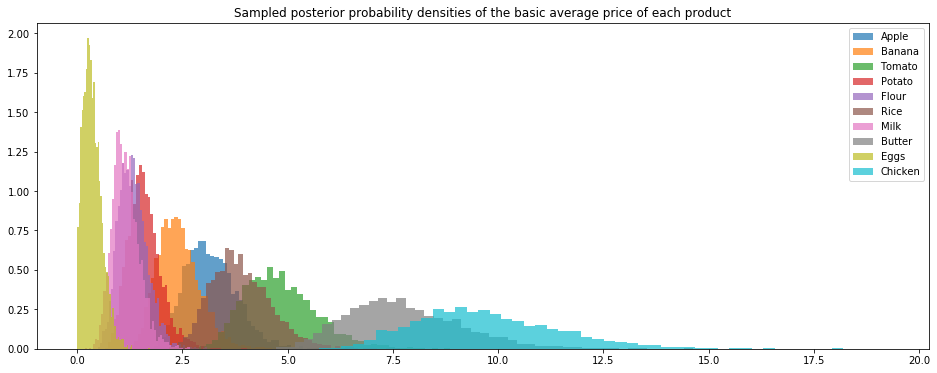

,Label,Mean,Posterior 95% confidence interval,Standard Error
0,Apple,3.19,"[2.1965731927522216, 4.566336590466279]",0.61
1,Banana,2.42,"[1.6058576892888405, 3.523476302410802]",0.50
2,Tomato,4.84,"[3.4502835623897377, 6.7996279979575025]",0.88
3,Potato,1.60,"[0.9524320601657283, 2.4831954151721756]",0.39
4,Flour,1.33,"[0.7636580887191294, 2.0811707993603146]",0.34
5,Rice,3.90,"[2.7311586149062173, 5.499650756438872]",0.72
6,Milk,1.15,"[0.6217806226266485, 1.8562028050485306]",0.32
7,Butter,7.77,"[5.548033227842655, 10.824727722791042]",1.39
8,Eggs,0.36,"[0.032778171659689305, 0.8620444927022644]",0.22
9,Chicken,9.74,"[6.981132237338909, 13.57530532881549]",1.74


In [53]:
products = pd.DataFrame(columns=['Label','Mean','Posterior 95% confidence interval','Standard Error'])
plt.figure(figsize = (16,6))
plt.title('Sampled posterior probability densities of the basic average price of each product')
for i in range(len(product_dict)):
    plt.hist(posterior_samples['base_prices'][:,i],bins=50, density=True, alpha = 0.7, label = product_dict[i+1])
    products.loc[i] = (product_dict[i+1],
                      round(np.mean(posterior_samples['base_prices'][:,i]),2),
                      np.percentile(posterior_samples['base_prices'][:,i], [2.5, 97.5]),
                      round(np.std(posterior_samples['base_prices'][:,i], ddof=1),2))
plt.legend()
plt.show()
products

 

*   How much the brand of the grocery store modifies the base price of the product




In [0]:
store_dict_1 = { 1: "ALDI", 2: "EDEKA", 3: "Lidl", 4: "REWE", 5: "Safeway", 
                6: "Sainsbury's", 7: "Tesco Express", 8: "Waitrose & Partners"}

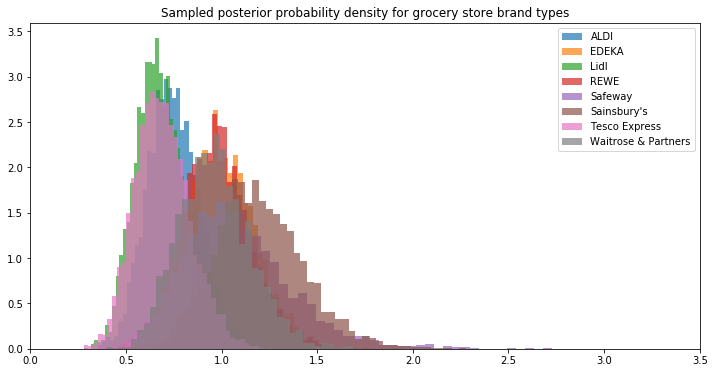

,Label,Mean,Posterior 95% confidence interval,Standard Error
0,ALDI,0.75,"[0.5041514979747821, 1.0453428877761752]",0.14
1,EDEKA,1.01,"[0.6803111726200888, 1.3802458818935475]",0.18
2,Lidl,0.67,"[0.4505500094797105, 0.9488597842530546]",0.13
3,REWE,0.98,"[0.6660027638496805, 1.3495373298541609]",0.17
4,Safeway,1.09,"[0.6220191596782533, 1.7507192614201321]",0.29
5,Sainsbury's,1.20,"[0.788200681564464, 1.696742795854143]",0.23
6,Tesco Express,0.69,"[0.4410182627186856, 1.0005190833798434]",0.14
7,Waitrose & Partners,0.97,"[0.6360525234222948, 1.3568899736172804]",0.19


In [55]:
brands = pd.DataFrame(columns=['Label','Mean','Posterior 95% confidence interval','Standard Error'])
plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for grocery store brand types')
for i in range(len(store_dict_1)):
    plt.hist(posterior_samples['grocery_store_multiplier'][:,i],bins=50, density=True, alpha = 0.7, label = store_dict_1[i+1])
    brands.loc[i] = (store_dict_1[i+1],
                      round(np.mean(posterior_samples['grocery_store_multiplier'][:,i]),2),
                      np.percentile(posterior_samples['grocery_store_multiplier'][:,i], [2.5, 97.5]),
                      round(np.std(posterior_samples['grocery_store_multiplier'][:,i], ddof=1),2))
plt.legend()
plt.xlim(0,3.5)
plt.show()
brands

### Check for statistical significance at the store level. 
####Since we're comparing averages, the t-test will be used


In [56]:
for i in range(len(store_dict_1)):
    for j in range(len(store_dict_1)):
        if i==j: continue
        
        z, p = sts.ttest_ind(posterior_samples['grocery_store_multiplier'][:,j],posterior_samples['grocery_store_multiplier'][:,i])
        if p > 0.05:
            print('Goods in ' + store_dict_1[i+1] + ' are not significantly pricier than those in ' + store_dict_1[j+1])
        if p < 0.05: 
            if z < 0: 
                print('Goods in ' + store_dict_1[i+1] + ' are significantly pricier than those in ' + store_dict_1[j+1])
            if z > 0:
                print('Goods in ' + store_dict_1[i+1] + ' are significantly cheaper than those in ' + store_dict_1[j+1]) 

Goods in ALDI are significantly cheaper than those in EDEKA
Goods in ALDI are significantly pricier than those in Lidl
Goods in ALDI are significantly cheaper than those in REWE
Goods in ALDI are significantly cheaper than those in Safeway
Goods in ALDI are significantly cheaper than those in Sainsbury's
Goods in ALDI are significantly pricier than those in Tesco Express
Goods in ALDI are significantly cheaper than those in Waitrose & Partners
Goods in EDEKA are significantly pricier than those in ALDI
Goods in EDEKA are significantly pricier than those in Lidl
Goods in EDEKA are significantly pricier than those in REWE
Goods in EDEKA are significantly cheaper than those in Safeway
Goods in EDEKA are significantly cheaper than those in Sainsbury's
Goods in EDEKA are significantly pricier than those in Tesco Express
Goods in EDEKA are significantly pricier than those in Waitrose & Partners
Goods in Lidl are significantly cheaper than those in ALDI
Goods in Lidl are significantly cheaper

*   How much the geographical location of the grocery store modifies the base price of the product



In [0]:
location_dict_1 = { 1: "Alt-Treptow", 2: "Barbican", 3: "Clapton", 4: "Crouch End", 5: "Elephants and Castle",
                 6: "Farringdon", 7: "Fitzrovia", 8: "Friedrichshain", 9: "Hoxton", 10: "Islington", 
                 11: "Kreuzberg", 12: "Lichtenberg", 13: "Marylebone", 14: "Mayfair", 15: "Mitte", 16: "Mountain View",
                 17: "Neukölln", 18: "Palo Alto", 19: "Prenzlauer Berg", 20: "Saint Pancras", 21: "San Francisco", 
                 22: "Schöneberg", 23: "Shoreditch", 24: "Tempelhof"}

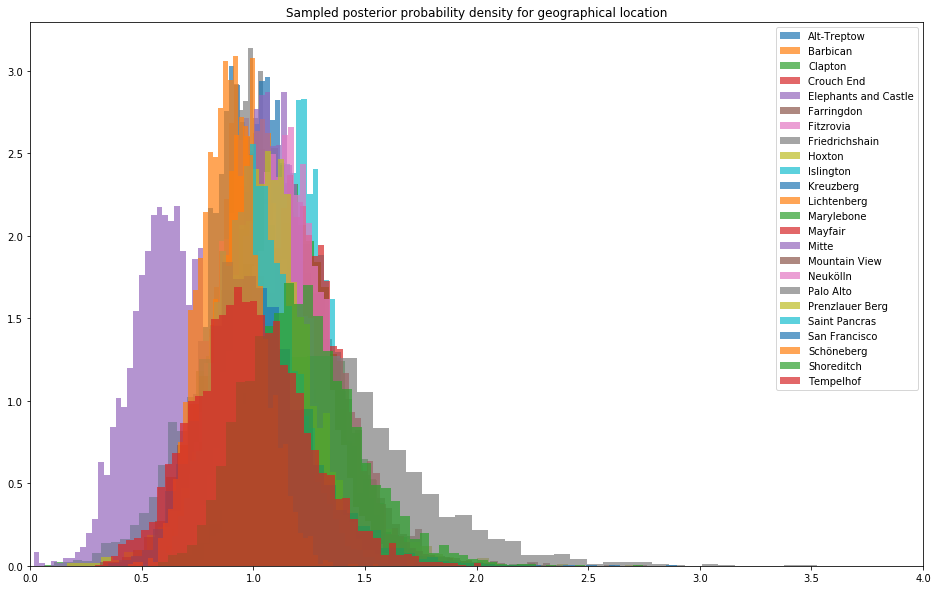

,Label,Mean,Posterior 95% confidence interval,Standard Error
0,Alt-Treptow,0.95,"[0.6886370036055408, 1.2438336644417942]",0.14
1,Barbican,1.08,"[0.7819857213801858, 1.4178406812794078]",0.16
2,Clapton,0.96,"[0.4366372380267186, 1.5452673625753235]",0.28
3,Crouch End,1.13,"[0.8225167471744985, 1.5276804264756114]",0.18
4,Elephants and Castle,0.64,"[0.30525548976695116, 1.0195990883097146]",0.19
5,Farringdon,1.22,"[0.8529358250160278, 1.698938173345764]",0.21
6,Fitzrovia,1.00,"[0.7146259352155747, 1.3415454184335218]",0.16
7,Friedrichshain,0.99,"[0.7442075455076619, 1.2710476719041413]",0.14
8,Hoxton,1.10,"[0.5708831879492743, 1.7085415372132398]",0.28
9,Islington,1.21,"[0.9359182794723604, 1.5418283252123062]",0.15


In [58]:
region = pd.DataFrame(columns=['Label','Mean','Posterior 95% confidence interval','Standard Error'])
plt.figure(figsize = (16,10))
plt.title('Sampled posterior probability density for geographical location')
for i in range(len(location_dict_1)):
    plt.hist(posterior_samples['location_multiplier'][:,i],bins=50, density=True, alpha = 0.7, label = location_dict_1[i+1])
    region.loc[i] = (location_dict_1[i+1],
                      round(np.mean(posterior_samples['location_multiplier'][:,i]),2),
                      np.percentile(posterior_samples['location_multiplier'][:,i], [2.5, 97.5]),
                      round(np.std(posterior_samples['location_multiplier'][:,i], ddof=1),2))
plt.legend()
plt.xlim(0,4)
plt.show()
region

### Check for statistical significance at the neighborhood level

In [59]:
for i in range(len(location_dict_1)):
    for j in range(len(location_dict_1)):
        if i==j: continue
        
        z, p = sts.ttest_ind(posterior_samples['location_multiplier'][:,j],posterior_samples['location_multiplier'][:,i])
        if p > 0.05:
            print('Goods in ' + location_dict_1[i+1] + ' are not significantly pricier than those in ' + location_dict_1[j+1])
        if p < 0.05: 
            if z < 0: 
                print('Goods in ' + location_dict_1[i+1] + ' are significantly pricier than those in ' + location_dict_1[j+1])
            if z > 0:
                print('Goods in ' + location_dict_1[i+1] + ' are significantly cheaper than those in ' + location_dict_1[j+1]) 

Goods in Alt-Treptow are significantly cheaper than those in Barbican
Goods in Alt-Treptow are significantly cheaper than those in Clapton
Goods in Alt-Treptow are significantly cheaper than those in Crouch End
Goods in Alt-Treptow are significantly pricier than those in Elephants and Castle
Goods in Alt-Treptow are significantly cheaper than those in Farringdon
Goods in Alt-Treptow are significantly cheaper than those in Fitzrovia
Goods in Alt-Treptow are significantly cheaper than those in Friedrichshain
Goods in Alt-Treptow are significantly cheaper than those in Hoxton
Goods in Alt-Treptow are significantly cheaper than those in Islington
Goods in Alt-Treptow are significantly cheaper than those in Kreuzberg
Goods in Alt-Treptow are significantly cheaper than those in Lichtenberg
Goods in Alt-Treptow are significantly cheaper than those in Marylebone
Goods in Alt-Treptow are significantly cheaper than those in Mayfair
Goods in Alt-Treptow are significantly cheaper than those in Mit

In [60]:
print("Greatest grocery store brand multiplier effect:", max(brands['Mean']))
print("Least grocery store brand multiplier effect:", min(brands['Mean']))
print("Greatest geographical location multiplier effect:", max(region['Mean']))
print("Least geographical location multiplier effect:", min(region['Mean']))

Greatest grocery store brand multiplier effect: 1.2
Least grocery store brand multiplier effect: 0.67
Greatest geographical location multiplier effect: 1.41
Least geographical location multiplier effect: 0.64


### Does price variation by geographical location correlate with variation in rental prices in Berlin/London, or not? 



In [0]:
berlin_neighborhoods = ["Alt-Treptow", "Friedrichshain", "Kreuzberg", "Lichtenberg", "Mitte", 
                        "Neukölln", "Prenzlauer Berg", "Schöneberg", "Tempelhof"]

berlin_neighborhoods_price_averages = []

for i in berlin_neighborhoods:
  s = region[region['Label']== i]
  berlin_neighborhoods_price_averages.append(float(s["Mean"]))


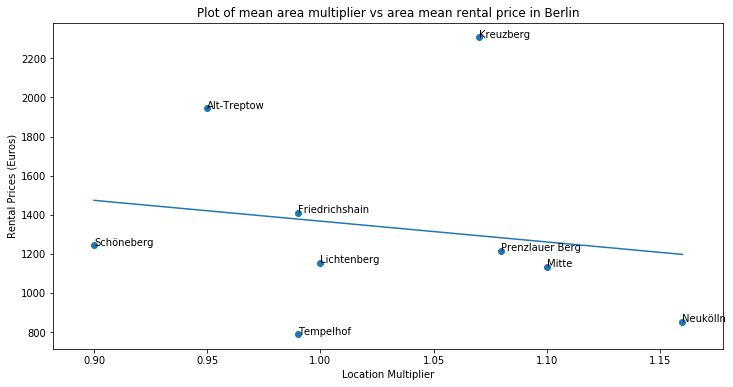

Pearson's Correlation Coeffiecient -0.17582487826895424


In [62]:
# Got the berlin rental price data by searching listed rentals on https://www.immobilienscout24.de/ by the 
# neighborhoods where the shops were located. Recorded the rental prices for the first 10
# housing units listed in each neighborhood

Alt_Treptow = [1470, 2741, 1600, 2099, 895, 1435, 2679, 3192, 2147, 1184]
Schöneberg = [1057, 3119, 434, 340, 2970, 2000, 585, 1100, 600, 1900]
Prenzlauer_Berg = [1749, 1459, 2849, 1197, 2490, 4680, 2498, 1998, 2890, 1258]
Neukölln = [668, 1710, 1440, 449, 1563, 1495, 832, 1215, 1162, 1000]
Mitte = [380, 1360, 1568, 1800, 1568, 1596, 1200, 680, 630, 550]
Lichtenberg = [1983, 779, 729, 1042, 632, 750, 579, 660, 585, 780]
Kreuzberg = [1249, 968, 1113, 1084, 1587, 1359, 1150, 507, 1575, 1555]
Friedrichshain = [712, 498, 1300, 1470, 1300, 1697, 1150, 1200, 1636, 1475]
Tempelhof = [950, 746, 760, 435, 746, 1097, 760, 655, 685, 1064]

x = berlin_neighborhoods_price_averages
y = []

berlin_property_prices = [Alt_Treptow, Schöneberg, Prenzlauer_Berg, Neukölln, Mitte,
                          Lichtenberg, Kreuzberg, Friedrichshain, Tempelhof]

for i in berlin_property_prices:
  y.append(np.mean(i))

plt.figure(figsize=(12, 6))
plt.scatter(x, y)
for el, text in enumerate(berlin_neighborhoods): #plotting area name on the plot
    plt.annotate(text, (x[el], y[el]))
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))) #fitting a best fit line to check the correlation
plt.title('Plot of mean area multiplier vs area mean rental price in Berlin')
plt.xlabel("Location Multiplier")
plt.ylabel("Rental Prices (Euros)")
plt.show()
print("Pearson's Correlation Coeffiecient", stats.pearsonr(x, y)[0])


In [0]:
london_neighborhoods = ["Barbican", "Clapton", "Crouch End", "Elephants and Castle", 
                        "Farringdon", "Fitzrovia","Hoxton", "Islington", 
                        "Marylebone", "Mayfair", "Saint Pancras", "Shoreditch"]

london_neighborhoods_price_averages = []

for i in london_neighborhoods:
  s = region[region['Label']== i]
  london_neighborhoods_price_averages.append(float(s["Mean"]))

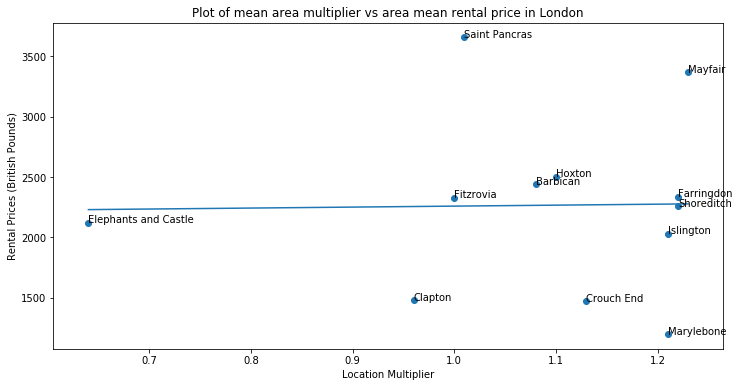

Pearson's Correlation Coeffiecient 0.018923157328351318


In [64]:
# Got the London rental price data by searching listed rentals on https://www.zoopla.co.uk/ by the 
# neighborhoods where the shops were located. Recorded the rental prices for the first 10
# housing units listed in each neighborhood


Barbican = [2427, 2600, 4312, 2250, 2600, 1820, 1000, 3012, 2350, 2058]
Clapton = [1101, 1400, 1300, 1600, 1750, 1300, 1400, 1452, 1700, 1800]
Crouch_End = [1647, 1950, 1400, 1600, 1250, 1625, 1560, 1625, 737, 1300]
Elephants_and_Castle = [1820, 1993, 3033, 800, 2730, 2730, 2167, 2383, 2080, 1473]
Farringdon = [2990, 1993, 800, 2383, 1800, 2275, 3250, 2275, 2600, 3012]
Fitzrovia = [3878, 1850, 3358, 2362, 2275, 1625, 1668, 2448, 2275, 1560]
Hoxton = [2648, 2253, 3100, 3012, 2492, 2275, 2492, 3100, 2600, 1049]
Islington = [2250, 2253, 2648, 2145, 2990, 1993, 600, 2012, 1300, 2100]
Marylebone = [1175, 1200, 1050, 1200, 1200, 1375, 1200, 1400, 1050, 1150]
Mayfair = [4160, 2167, 3250, 3207, 3250, 4225, 2947, 4117, 2492, 3878]
Saint_Pancras = [3250, 1543, 3592, 2999, 4400, 3680, 6338, 7220, 1170, 2383]
Shoreditch = [2253, 2648, 1993, 2102, 2100, 3359, 1185, 1200, 2920, 2817]

x_1 = london_neighborhoods_price_averages
y_1 = []

london_property_prices = [Barbican, Clapton, Crouch_End, Elephants_and_Castle, Farringdon, 
                          Fitzrovia, Hoxton, Islington, Marylebone, Mayfair, Saint_Pancras, Shoreditch]

for i in london_property_prices:
  y_1.append(np.mean(i))

plt.figure(figsize=(12, 6))
plt.scatter(x_1, y_1)
for el, text in enumerate(london_neighborhoods): 
    plt.annotate(text, (x_1[el], y_1[el]))
plt.plot(np.unique(x_1), np.poly1d(np.polyfit(x_1, y_1, 1))(np.unique(x_1)))
plt.title('Plot of mean area multiplier vs area mean rental price in London')
plt.xlabel("Location Multiplier")
plt.ylabel("Rental Prices (British Pounds)")
plt.show()
print("Pearson's Correlation Coeffiecient", stats.pearsonr(x_1, y_1)[0])